In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import os
import cv2
from tqdm import tqdm

In [ ]:
def convertjpg(jpgfile,outdir,width=64,height=64):
    img=Image.open(jpgfile)   
    new_img=img.resize((width,height),Image.BILINEAR)   
    new_img.save(os.path.join(outdir,os.path.basename(jpgfile)))
for jpgfile in glob.glob('/root/autodl-tmp/thispersondoesnotexist.10k/*.jpg'):
    convertjpg(jpgfile,'/root/autodl-tmp/thispersondoesnotexist.10k')
for jpgfile in glob.glob('/root/autodl-tmp/0/*.jpg'):
    convertjpg(jpgfile,'/root/autodl-tmp/0')

In [2]:
def getFileName(filepath):
    path_list = []
    pathList = os.listdir(filepath)
    for allFile in pathList:
        everyFile = os.path.join(filepath, allFile)
        path_list.append(everyFile)
    return path_list
training_path = getFileName('/root/autodl-tmp/thispersondoesnotexist.10k')
testing_path = getFileName('/root/autodl-tmp/0')

In [3]:
training_path = training_path[:10000]

In [4]:
testing_img_path = training_path[:800] + testing_path[:200]
training_img_path = training_path[800:]

In [5]:
test_y = 800*[0] + 200*[1]
test_y = np.array(test_y)

In [6]:
train = np.array([cv2.imdecode(np.fromfile(path,dtype=np.uint8),-1)/ 255. for path in training_img_path])
train = train.reshape(9200,64,64,3)
print(train.shape)
test = np.array([cv2.imdecode(np.fromfile(path,dtype=np.uint8),-1)/ 255. for path in testing_img_path])
test = test.reshape(1000,64,64,3)
print(test.shape)

(9200, 64, 64, 3)
(1000, 64, 64, 3)


In [7]:
train_neg = [t.reshape(t.shape[0]* t.shape[1] * t.shape[2]) for t in train]
test_tmp = [t.reshape(t.shape[0]* t.shape[1] * t.shape[2]) for t in test]

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(train_neg)

PCA(n_components=2)

In [39]:
pca_train_data = pca.transform(train_neg)

In [40]:
pca_test_data = pca.transform(test_tmp)

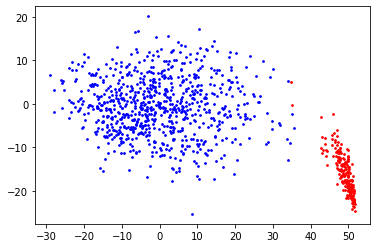

In [42]:
fig = plt.figure()
ax = plt.axes()
xdata_1 = pca_test_data[:800,0]
ydata_1 = pca_test_data[:800,1]
xdata_2 = pca_test_data[800:,0]
ydata_2 = pca_test_data[800:,1]
ax.scatter(xdata_1, ydata_1, c = 'blue', s = 3)
ax.scatter(xdata_2, ydata_2, c = 'red', s = 3)

In [43]:
train_neg_rec = pca.inverse_transform(pca_train_data)
test_tmp_rec = pca.inverse_transform(pca_test_data)

In [44]:
def get_anomaly_scores(df_original, df_restored):
    loss = np.mean((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    return loss
 
train_scores = get_anomaly_scores(train_neg, train_neg_rec)
test_scores = get_anomaly_scores(test_tmp, test_tmp_rec)

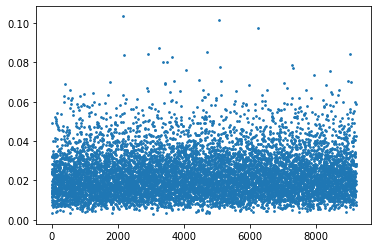

In [45]:
a = np.linspace(0, 9200, 9200)
plt.scatter(a, np.array(train_scores), s = 3)

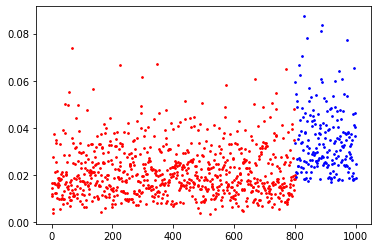

In [46]:
a = np.linspace(0, 800, 800)
plt.scatter(a, np.array(test_scores[0:800, ]), color = 'red', s=3)
b = np.linspace(800, 1000, 200)
plt.scatter(b, np.array(test_scores[800:, ]), color = 'blue', s=3)  

In [47]:
from sklearn.metrics import accuracy_score,f1_score
threshold = np.linspace(0, 1, 5000)
acc_list = []
f1_list = []
for t in threshold:    
    y_pred = (test_scores>t).astype(np.int64)
    acc_list.append(accuracy_score(y_pred,test_y))
    f1_list.append(f1_score(y_pred,test_y))

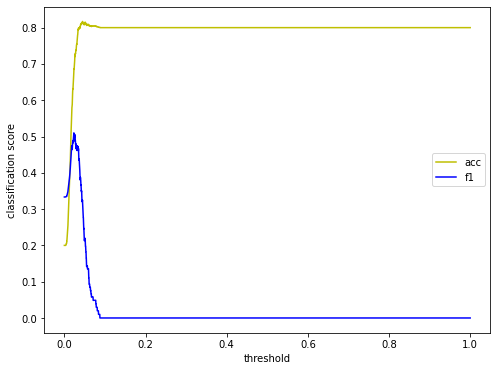

In [48]:
plt.figure(figsize=(8,6))
plt.plot(threshold,acc_list,c = 'y',label = 'acc')
plt.plot(threshold,f1_list,c = 'b',label = 'f1')
plt.xlabel('threshold')
plt.ylabel('classification score')
plt.legend()

In [49]:
i = np.argmax(f1_list)
t = threshold[i]
score = f1_list[i]
print('Recommended threshold: %.3f, related f1 score: %.3f'%(t,score))

y_pred = (test_scores>t).astype(np.int64)
y_pred = y_pred.reshape(1000,1)
test_y = test_y.reshape(1000,1)
TP = ((test_y==1) & (y_pred==1)).sum()
FN = ((test_y==1) & (y_pred==0)).sum()
FP = ((test_y==0) & (y_pred==1)).sum()
TN = ((test_y==0) & (y_pred==0)).sum()
print('In %d data of test set, TP: %d, FN: %d, FP: %d, TN: %d'%(len(test_y),TP,FN,FP,TN))

Recommended threshold: 0.023, related f1 score: 0.510
In 1000 data of test set, TP: 166, FN: 34, FP: 285, TN: 515


In [50]:
i = np.argmax(acc_list)
t = threshold[i]
score = acc_list[i]
print('Recommended threshold: %.3f, related acc score: %.3f'%(t,score))

y_pred = (test_scores>t).astype(np.int64)
y_pred = y_pred.reshape(1000,1)
test_y = test_y.reshape(1000,1)
TP = ((test_y==1) & (y_pred==1)).sum()
FN = ((test_y==1) & (y_pred==0)).sum()
FP = ((test_y==0) & (y_pred==1)).sum()
TN = ((test_y==0) & (y_pred==0)).sum()
print('In %d data of test set, TP: %d, FN: %d, FP: %d, TN: %d'%(len(test_y),TP,FN,FP,TN))

Recommended threshold: 0.045, related acc score: 0.817
In 1000 data of test set, TP: 44, FN: 156, FP: 27, TN: 773


In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
test_tsne_data = tsne.fit_transform(test_tmp)

/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


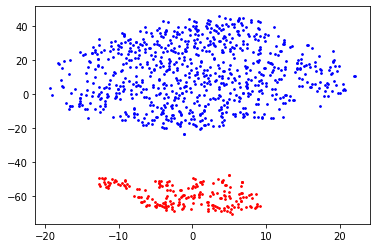

In [37]:
fig = plt.figure()
ax = plt.axes()
xdata_1 = test_tsne_data[:800,0]
ydata_1 = test_tsne_data[:800,1]
xdata_2 = test_tsne_data[800:,0]
ydata_2 = test_tsne_data[800:,1]
ax.scatter(xdata_1, ydata_1, c = 'blue', s = 3)
ax.scatter(xdata_2, ydata_2, c = 'red', s = 3)